# LAB4: Bearing Fault Detection using 1D CNN

###### By M. Ahmed Ouameur 


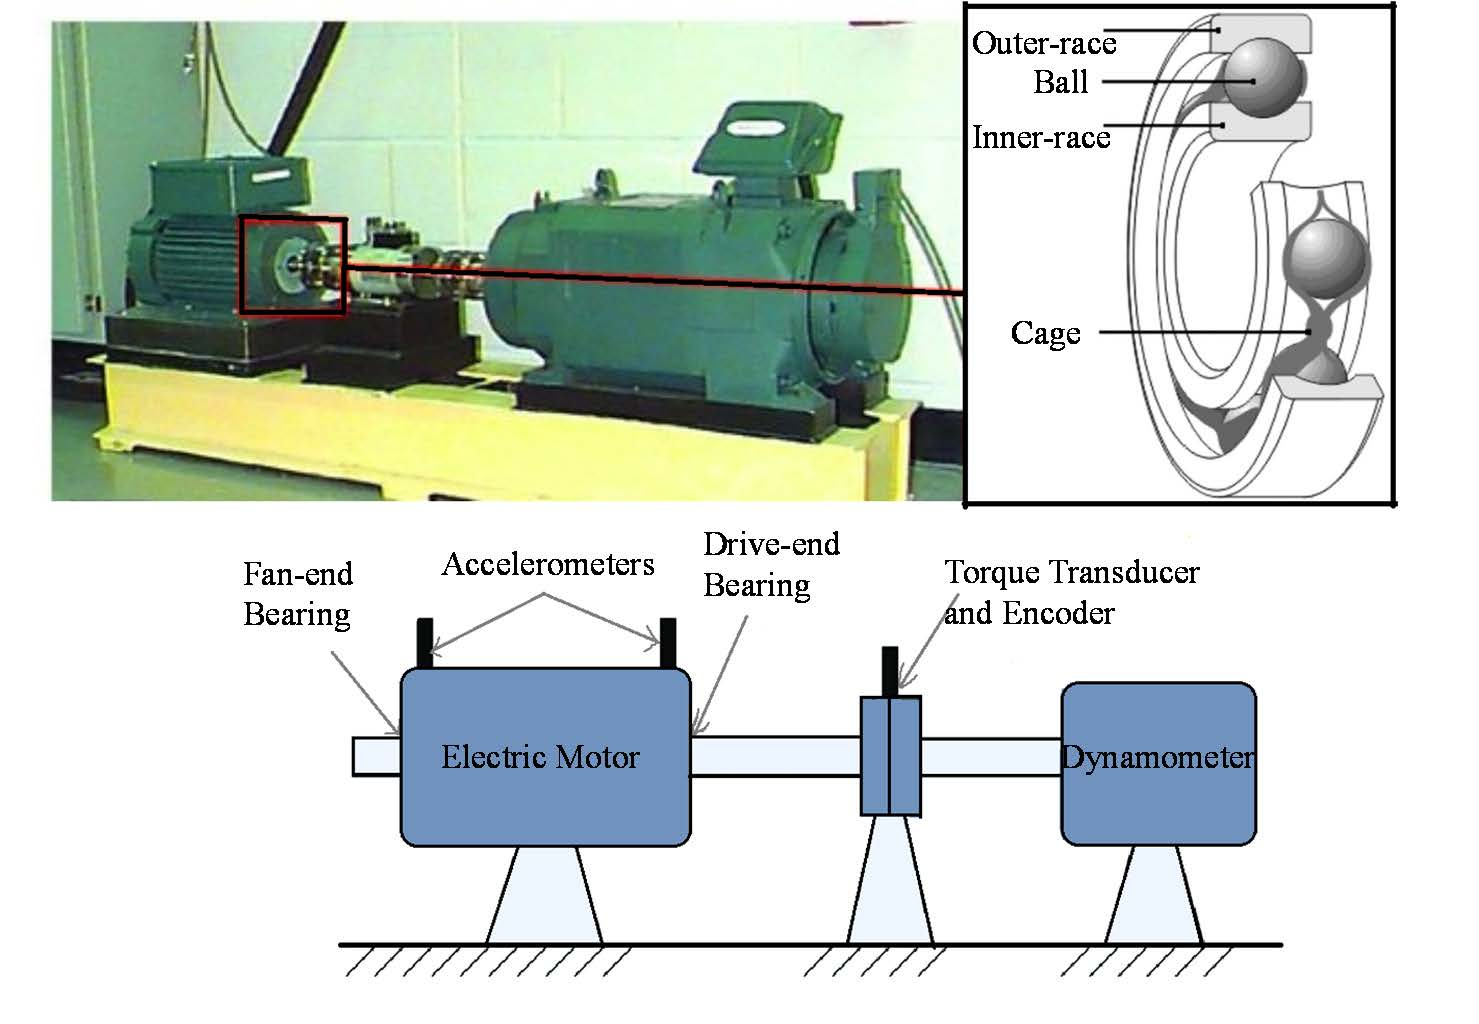

In [1]:
from IPython.display import Image
Image(filename='./images/CWRU bearing test rig system.jpeg', width=400) 

## Objective:
This lab focuses on fault detection in bearings using deep learning. The system utilizes vibration signals from the CWRU Bearing Dataset to classify different types of bearing faults. A 1D Convolutional Neural Network (1D CNN) is employed to extract meaningful features from time-series vibration data and classify faults into predefined categories.

The methodology used in this lab is inspired by the research presented in the following paper:
"CNN-Based Fault Detection for Smart Manufacturing"
Available at: https://www.mdpi.com/2076-3417/11/24/11732

It includes three parts:
- **Part 1**: A baseline CNN without data augmentation.
- **Part 2**: An improved CNN trained with data augmentation
- **Part 3**: A deeper CNN with 6 Conv1D layers trained on augmented data
  
Performance is evaluated using accuracy, loss plots, confusion matrices, and classification reports.


## Dataset:
The dataset used in this project is a subset of the Case Western Reserve University (CWRU) Bearing Dataset, specifically focusing on four key conditions:

1️⃣ Normal Bearings (Healthy Condition)

2️⃣ Ball Faults

3️⃣ Inner Race Faults

4️⃣ Outer Race Faults (Centered @6:00 Position)

We selected bearing vibration signals corresponding to faults located at the centered position (6:00) under different motor loads and speeds. These signals were recorded under motor speeds ranging from 1730 to 1797 RPM at a sampling rate of 48 kHz. The dataset is used to classify bearing conditions based on the extracted vibration features.


In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input,Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import models

# Part 1:
Follow these key steps:
1. Load vibration data from `.mat` files.
2. Preprocess and segment the signals.
3. Prepare the dataset for training.
4. Build and train a 1D CNN model for fault classification.
5. Evaluate and visualize the model's performance.

## Step 1: Load Vibration Data from `.mat` Files
#### Read all `.mat` files in the dataset and extract vibration signals.

Note: In the CWRU dataset, each .mat file contains multiple vibration signals, typically from the Drive End (DE), Fan End (FE), and motor speed (RPM).
Among them, the Drive End (DE) signal is most commonly used for fault diagnosis because:

- It is directly connected to the motor and bearings, capturing faults more clearly.

- DE signals generally have higher signal quality and stronger fault signatures.

- Most research papers and benchmark models focus on DE data for consistency and comparability.

Therefore, we extract only the '_DE_time' signal from each file and skip the rest.


In [3]:
def load_mat_files(directory, label, segment_size=1600, signal_type="DE"):
    """
    Load vibration signal data from CWRU dataset.

    Parameters:
    - directory: Path to the folder containing .mat files
    - label: Integer label for the dataset 
        (0 = Normal, 
         1 = Ball Fault, 
         2 = Inner Race Fault, 
         3 = Outer Race Fault)
    - segment_size: Number of data points per sample (Default: 1600)
    - signal_type: "DE" for Drive End, "FE" for Fan End (Default: "DE")

    Returns:
    - data: Numpy array of extracted signal segments
    - labels: Numpy array of corresponding labels
    """
    data = []
    labels = []

    file_list = os.listdir(directory)
  
    for file in file_list:
        if file.endswith(".mat"):
            file_path = os.path.join(directory, file)
            print(f"📂 Loading file: {file_path}")

            try:
                mat_data = scipy.io.loadmat(file_path)
                keys = list(mat_data.keys())
                print(f"🔑 Keys in {file}: {keys}") 
                
                signal_key = next((k for k in keys if f"_{signal_type}_time" in k), None)
                if signal_key is None:
                    print(f"⚠ Skipping {file} (No matching key for {signal_type})")
                    continue

                vibration_signal = mat_data[signal_key].flatten()

                for i in range(0, len(vibration_signal) - segment_size, segment_size):
                    segment = vibration_signal[i:i+segment_size]
                    data.append(segment)
                    labels.append(label)

            except Exception as e:
                print(f"Error loading {file}: {e}")

    if len(data) == 0:
        print(f"⚠ Warning: No valid data extracted from {directory}!")

    return np.array(data), np.array(labels)


❓Q: Analyze the following function `load_mat_files()`. Explain its purpose and describe step by step how it processes the input files. Your explanation should cover:

- What kind of data this function is meant to load and from which dataset.
- The meaning of its parameters.
- How it handles the .mat files and extracts segments.
- What the function returns.
- Any potential issues or exceptions it handles.

✅ A: 
As mentioned in the title, this function was created to load different types of signal data of bearings in a motor. The data comes from the CRWU Bearing Data set. We focus especially on the Drive End signal as previous researchers found richer data from that part. 
For the parameters, the comments are very useful to help us understand them. There are 4 parameters for this function, and only the directory and label do not have default values if users don't enter any. Obviously, the directory parameter corresponds to the path of the folder with the data we want to extract (specifically .mat files in this case). The label parameter can take from integer values 0 to 3 in which we specify the exact fault we wish to observe or if the data is not faulty (0). The segment_size parameter is the number of data points per signal whereas the signal_type is the location of the signal such as the Drive end or Front End (possibly RPM also).
First of all, in the function, in the directory given, it checks for files that have a .mat extension #TODO

For the returns, as mentioned in the header, it returns an array of extracted signal segments and an array with the labels for the signal segments. 

This function handles basically all errors in loading the .mat file with the try and except keywords, which entails that any errors will be handled in the except which in this case prints to the screen that an error occured without more details about it. Also, if no values were appended to the data table, there will be a warning for the user mentionning no data was loaded. #TODO

## Step 2: Load Data from All Categories
### Load data for:
### - Normal bearings
### - Faulty bearings (Ball, Inner Race, Outer Race)

In [4]:
data_dir = "CWRU/"

normal_data, normal_labels = load_mat_files(os.path.join(data_dir, "Normal_Baseline_Data"), label=0)

#❓Q: Complete the line of code to load data for the Ball fault condition with label 1?
ball_data, ball_labels = load_mat_files(os.path.join(data_dir, "48k_Drive_End_Bearing_Fault_Data", "Ball"), label=1)

#❓Q: Complete the line of code to load data for the Inner race fault condition with label 2?
inner_race_data, inner_race_labels = load_mat_files(os.path.join(data_dir, "48k_Drive_End_Bearing_Fault_Data", "Inner_Race"), label=2)

outer_race_data, outer_race_labels = load_mat_files(os.path.join(data_dir, "48k_Drive_End_Bearing_Fault_Data", "Outer_Race_Centered-6"), label=3)


📂 Loading file: CWRU/Normal_Baseline_Data\100.mat
🔑 Keys in 100.mat: ['__header__', '__version__', '__globals__', 'X100_DE_time', 'X100_FE_time', 'X100RPM']
📂 Loading file: CWRU/Normal_Baseline_Data\97.mat
🔑 Keys in 97.mat: ['__header__', '__version__', '__globals__', 'X097_DE_time', 'X097_FE_time', 'X097RPM']
📂 Loading file: CWRU/Normal_Baseline_Data\98.mat
🔑 Keys in 98.mat: ['__header__', '__version__', '__globals__', 'X098_DE_time', 'X098_FE_time']
📂 Loading file: CWRU/Normal_Baseline_Data\99.mat
🔑 Keys in 99.mat: ['__header__', '__version__', '__globals__', 'ans', 'X098_DE_time', 'X098_FE_time', 'X099_DE_time', 'X099_FE_time']
📂 Loading file: CWRU/48k_Drive_End_Bearing_Fault_Data\Ball\122.mat
🔑 Keys in 122.mat: ['__header__', '__version__', '__globals__', 'X122_DE_time', 'X122_FE_time', 'X122RPM']
📂 Loading file: CWRU/48k_Drive_End_Bearing_Fault_Data\Ball\123.mat
🔑 Keys in 123.mat: ['__header__', '__version__', '__globals__', 'X123_DE_time', 'X123_FE_time', 'X123RPM']
📂 Loading fil

## Step 3: Prepare Dataset for Training
### Normalize and reshape the dataset to match the CNN input format.

In [15]:
# Verify Data Shapes and Prepare for Training

datasets = [normal_data, ball_data, inner_race_data, outer_race_data]
# ❓ Q: Complete the code below to print the shape of each dataset for debugging?
print("Normal Data Shape:", normal_data.shape)
print("Ball Fault Data Shape:", ball_data.shape)
print("Inner Race Fault Data Shape:", inner_race_data.shape)
print("Outer Race Fault Data Shape:", outer_race_data.shape)

#❓Q: Complete the code below to raise an error if any of the datasets are empty?
if any(d.size ==0 for d in datasets):
    raise ValueError("Error: One or more datasets are empty! Please check the data loading step.")

#❓Q: Complete the code to stack the datasets and labels together?
data = np.concatenate((normal_data, ball_data, inner_race_data, outer_race_data))
labels = np.concatenate((normal_labels, ball_labels, inner_race_labels, outer_race_labels))
# Normalize data to range [-1,1]
data = data / np.max(np.abs(data))

# Reshape for CNN input (samples, time_steps, 1)
data = data.reshape(data.shape[0], data.shape[1], 1)

#❓Q: Complete the code to split the dataset into training and testing sets, using 20% of the data for testing and a fixed random seed of 42?
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.80, test_size=0.2, random_state=42)

print("Data successfully prepared for training!")
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Normal Data Shape: (1059, 1600)
Ball Fault Data Shape: (3195, 1600)
Inner Race Fault Data Shape: (3081, 1600)
Outer Race Fault Data Shape: (3195, 1600)
Data successfully prepared for training!
Training Set: (8424, 1600, 1), Testing Set: (2106, 1600, 1)


❓Q: What do the above shapes represent in the context of CNN input for vibration signal classification?

✅A:  #TODO

## Step 4: Build the 1D CNN Model
### Create a 1D CNN with convolutional, pooling, and fully connected layers.

In [32]:
from tensorflow.keras.layers import Input

model_part1 = Sequential([
    Input(shape=(1600, 1)),  # Define input shape separately
    Conv1D(filters=32, kernel_size=3, padding='same'),
    Activation('relu'),
    MaxPooling1D(pool_size=2),
    
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
   
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


model_part1.compile(optimizer=Adam(learning_rate=0.0002),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_part1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1600, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 798, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 399, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 397, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25344)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,244,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,275,716 (12.50 MB)

 Trainable params: 3,275,716 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

Answer these questions based on step 4:

❓Q: What is the purpose of the following line?

    A. It defines a 2D image input
    B. It defines the expected shape of 1D vibration signal input
    C. It automatically normalizes the input
    D. It sets the batch size
    
✅A: #TODO

❓Q: Which layer is responsible for reducing the temporal dimension after convolution?

    A. Conv1D
    B. Activation('relu')
    C. MaxPooling1D
    D. Dropout
    
✅A: C. MaxPooling1D

❓Q: What does the final `Dense(4, activation='softmax')` layer represent?

    A. It creates 4 convolutional filters
    B. It generates a 4-class probability output for classification
    C. It flattens the input
    D. It drops 4 neurons randomly

✅A: It generates a 4-class probability output for classification

❓Q:  B. What is the function of the Dropout(0.5) layer?

✅A: #TODO

❓Q: Why is 'sparse_categorical_crossentropy' used instead of 'categorical_crossentropy'?

✅A: #TODO

## Step 5: Train the Model
## Train the model using the training dataset and validate it with the test dataset.

In [17]:
# Stop training if validation loss doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
#❓Q: Complete the code to train the model using 50 epochs, batch size 64, and early stopping based on validation loss?
history_part1 = model_part1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

#❓Q: What is the purpose of the EarlyStopping callback in this code?
#✅A: I believe it is to avoid the model becoming too specialized on the training set which causes it to lose generalization capabilities on unseen data.

#❓Q: What does the argument patience=5 mean in the context of EarlyStopping?
#✅A: If after 5 consecutives swipes of the dataset the precision decreases, the training will stop and since we set the argument restore_best_weights=True then it will go back to the best weights used.

#❓Q: What does restore_best_weights=True do in this setting?
#✅A: It searches back for the best weights after 5 consecutive losses in precision of the model

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4060 - loss: 1.1745 - val_accuracy: 0.6391 - val_loss: 0.8816
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6276 - loss: 0.8782 - val_accuracy: 0.7583 - val_loss: 0.7516
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7243 - loss: 0.7338 - val_accuracy: 0.8148 - val_loss: 0.6315
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7699 - loss: 0.6500 - val_accuracy: 0.8224 - val_loss: 0.5633
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8071 - loss: 0.5719 - val_accuracy: 0.8272 - val_loss: 0.5066
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8184 - loss: 0.5254 - val_accuracy: 0.8376 - val_loss: 0.4604
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8280 - loss: 0.4988 - val_accuracy: 0.8419 - val_loss: 0.4391
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8324 - loss: 0.4714 - v

## Step 6: Evaluate the Model
## Visualization of Training Performance

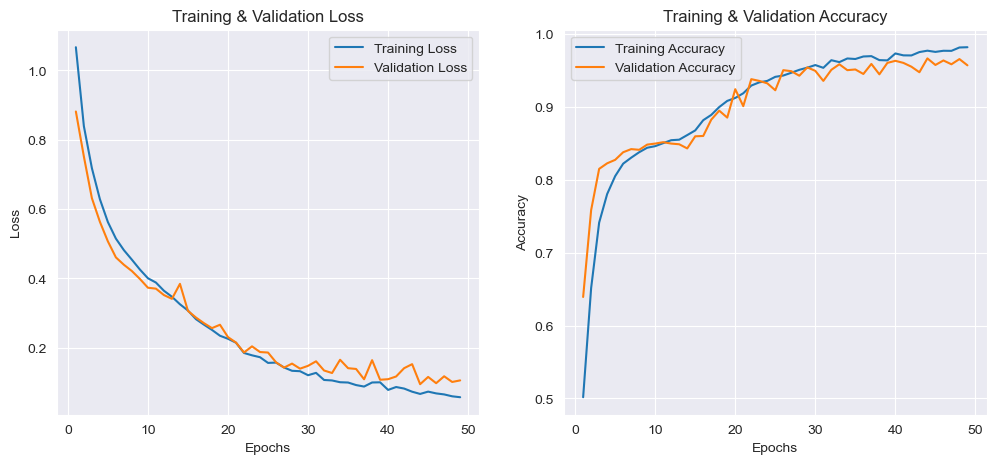

In [28]:
# Extract loss and accuracy from training history

history = history_part1
epochs = range(1, len(history.history['loss']) + 1)

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


❓ Q: Look at the Training & Validation Loss and Accuracy curves. What do these plots tell you about the model's training performance? Discuss whether the model is overfitting, underfitting, or well-generalized, and explain your reasoning.

✅A: It is well-generalized because the validation keeps on going down and the validation accuracy keeps on going up as the number of epochs increases. I believe we could train on more than 50 epochs at this point.

## Step7: Classification Report and Confusion Matrix

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report (Part 1):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       0.95      0.94      0.94       638
           2       0.96      0.96      0.96       609
           3       0.98      0.98      0.98       642

    accuracy                           0.97      2106
   macro avg       0.97      0.97      0.97      2106
weighted avg       0.97      0.97      0.97      2106



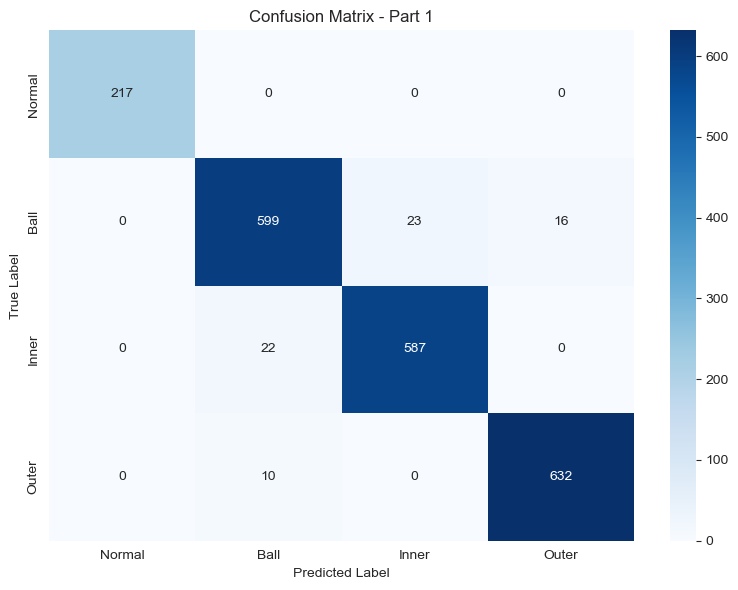

In [30]:
# Predict class labels
#❓Q:Complete the code to generate class predictions for the test set?
y_pred_part1 = model_part1.predict(X_test)
y_pred_classes_part1 = np.argmax(y_pred_part1, axis=1)

# Print classification report
print("Classification Report (Part 1):")
print(classification_report(y_test, y_pred_classes_part1))

# Confusion matrix
# ❓Q:Complete the code to compute and visualize the confusion matrix
conf_matrix_part1 = confusion_matrix(y_test,y_pred_classes_part1)

plt.figure(figsize=(8, 6))
class_labels = ['Normal', 'Ball', 'Inner', 'Outer']
sns.heatmap(conf_matrix_part1, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Part 1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


❓Q: Analyze the classification report and confusion matrix. What does the model seem to do well, and where does it make mistakes? Comment on the precision, recall, and F1-score for each class, and discuss whether this performance would be acceptable in a real-world bearing fault detection system.

✅A:

## Step 8: Visualizing Feature Evolution Across Conv1D Layers
Extract and visualize the output of a specific feature (Feature 0) as it flows through each convolutional layer in a trained 1D CNN model. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


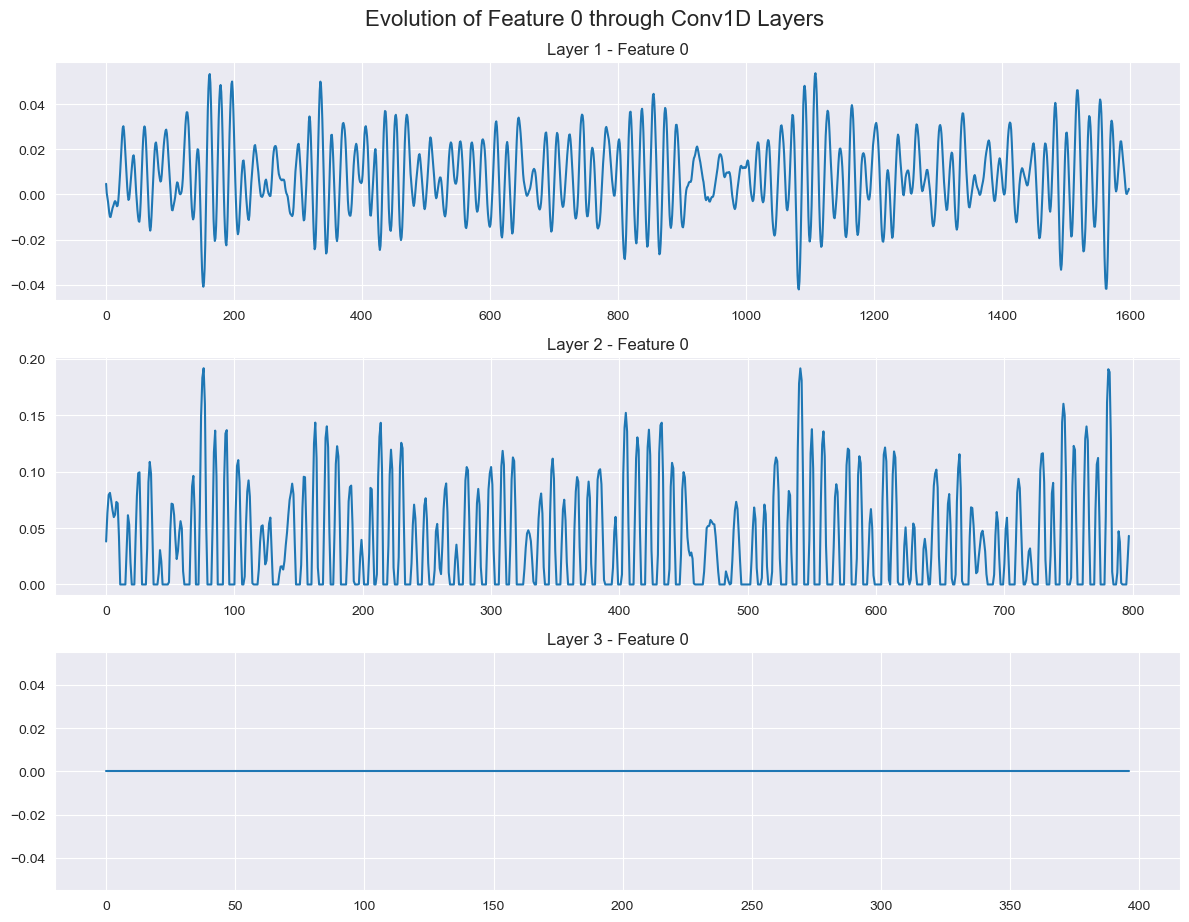

In [31]:
# Pick one input sample
sample = X_test[0]
sample_input = np.expand_dims(sample, axis=0)

# Get all Conv1D layer outputs
conv_outputs = [layer.output for layer in model_part1.layers if isinstance(layer, tf.keras.layers.Conv1D)]
activation_model = models.Model(inputs=model_part1.layers[0].input, outputs=conv_outputs)

# Get feature maps for all conv layers
feature_maps = activation_model.predict(sample_input)

# Plot one feature from each layer (e.g., feature index 0)
feature_index = 0

plt.figure(figsize=(12, len(feature_maps) * 3))
for i, fmap in enumerate(feature_maps):
    plt.subplot(len(feature_maps), 1, i + 1)
    plt.plot(fmap[0, :, feature_index])
    plt.title(f"Layer {i+1} - Feature {feature_index}")
    plt.tight_layout()

plt.suptitle("Evolution of Feature 0 through Conv1D Layers", fontsize=16, y=1.02)
plt.show()


❓ Q: Based on the visualization of feature 0 across the Conv1D layers, describe how the raw input signal is transformed as it moves through the convolutional layers. What trends do you observe, and what does this tell you about how the CNN extracts meaningful features from vibration data?

✅A: 

# Part 2: Enhancing CNN Model with Data Augmentation

## Step 1: Data Augmentation Functions 

In [24]:
#❓Q: Complete the function to perform data augmentation on 1D vibration signals by applying noise, shifting, scaling, and jittering?

def enhanced_augment_signal(signal, noise_level=0.001, shift_max=150, scale_range=(0.85, 1.15), jitter_std=0.0015):
    signal = tf.cast(signal, tf.float32)

    # 1. Add Gaussian noise
    noise = tf.random.normal(tf.shape(signal), mean=0.0, stddev=xxxx)
    signal = signal + noise

    # 2. Random shift
    shift = tf.random.uniform([], -shift_max, shift_max, dtype=xxxx)
    signal = tf.roll(signal, shift, axis=0)

    # 3. Random scaling
    scale = tf.random.uniform([], xxxx[0], xxxx[1])
    signal = signal * scale

    # 4. Jittering (light noise)
    jitter = tf.random.normal(tf.shape(signal), stddev=xxxx)
    signal = signal + jitter

    return signal

#❓ Q: Complete the code below to apply the above augmentation to the training data and combine with the original dataset?
# Apply augmentation to training data
X_train_aug = np.array([xxxx(x).numpy() for x in X_train])
y_train_aug = y_train.copy()

# Combine original and augmented data
X_train_combined = np.vstack([xxxx, xxxx])
y_train_combined = np.hstack([xxxx, xxxx])

## Step 2: Visualize Original vs. Augmented Signals

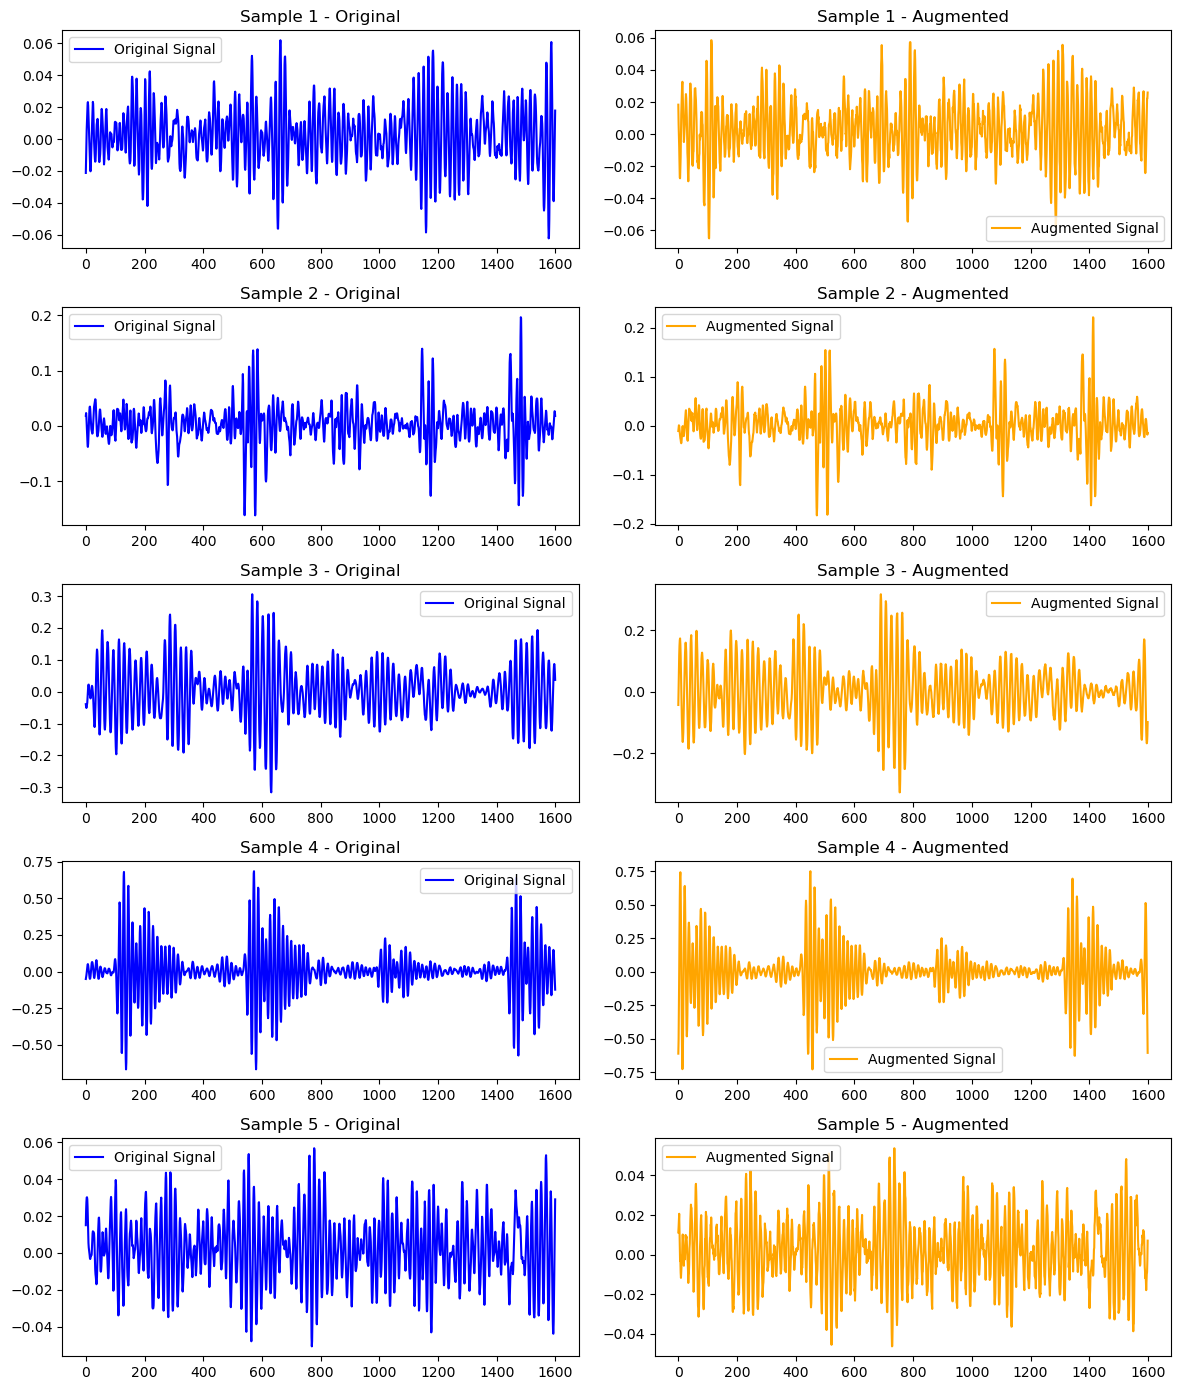

In [26]:
fig, axes = plt.subplots(5, 2, figsize=(12, 14))

for i in range(5):
    idx = np.random.randint(len(X_train))
    original_signal = X_train[idx]
    augmented_signal = enhanced_augment_signal(original_signal).numpy()

    # Original Signal
    axes[i, 0].plot(original_signal, label='Original Signal', color='blue')
    axes[i, 0].set_title(f'Sample {i+1} - Original')
    axes[i, 0].legend()

    # Augmented Signal (Gaussian Noise + Shifted)
    axes[i, 1].plot(augmented_signal, label='Augmented Signal', color='orange')
    axes[i, 1].set_title(f'Sample {i+1} - Augmented')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


❓Q:Look at the plots showing the original and augmented vibration signals. What changes can you see in the augmented signals? Why do you think adding such changes can help train a better machine learning model?

✅A:

## Step 3: Define CNN Model

In [28]:
#❓Q:Based on the model summary shown and using the same structure as in Part 1, 
#  write the complete code to define, compile, and summarize a new CNN model (Part 2) with the following specifications:
# Input shape: (1600, 1)
# 3 Conv1D layers with 32, 64, and 128 filters respectively
# Kernel size: 3
#Activation: 'relu'
#Pooling: MaxPooling1D with pool size 2 after each Conv1D
#Dense layer with 128 units and 'relu' activation
#Dropout rate: 0.5
#Output layer: Dense with 4 units and 'softmax'
#Optimizer: Adam with learning rate 0.0002
#Loss: 'sparse_categorical_crossentropy'
#Metric: 'accuracy'

model_part2 = xxxx([
    XXXX
])


model_part2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 1600, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1600, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 800, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 798, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 399, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 397, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 198, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25344)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,244,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,275,716 (12.50 MB)

 Trainable params: 3,275,716 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Train the Model with EarlyStopping and Augmented Data

In [30]:
#❓Q: Write the complete code to train model_part2 using EarlyStopping and the augmented training dataset.
# Use the following conditions:
#Training data: X_train_combined, y_train_combined (original + augmented)
#Validation data: X_test, y_test
#Epochs: 50
#Batch size: 64
#EarlyStopping: monitor 'val_loss', patience 5, restore best weights
#Make sure your code uses the EarlyStopping callback correctly and includes the combined dataset for training.

early_stopping = xxxx

history_part2 = xxxx
    xxxx
)

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.4369 - loss: 1.1088 - val_accuracy: 0.7707 - val_loss: 0.7176
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.7310 - loss: 0.7024 - val_accuracy: 0.8186 - val_loss: 0.5555
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8069 - loss: 0.5552 - val_accuracy: 0.8310 - val_loss: 0.4657
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8212 - loss: 0.4887 - val_accuracy: 0.8395 - val_loss: 0.4191
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8368 - loss: 0.4286 - val_accuracy: 0.8481 - val_loss: 0.3663
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8445 - loss: 0.3914 - val_accuracy: 0.8561 - val_loss: 0.3143
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8555 - loss: 0.3276 - val_accuracy: 0.8628 - val_loss: 0.2686
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8704 - loss: 0.2993 -

## Step 5: Visualization of Training Performance

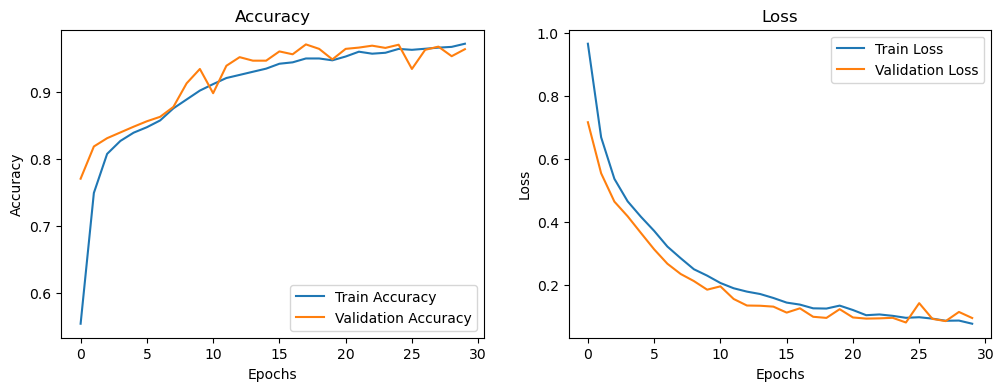

In [32]:
history = history_part2

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

❓Q: By analyzing the training and validation curves in the plots above, how does the model's performance with augmented data (Part 2) compare to the performance without augmentation (Part 1)? What can you conclude about the effect of data augmentation on the model's generalization ability?

✅A:

## Step 6: Classification Report and Confusion Matrix

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step 
Classification Report (Part 2):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       0.96      0.95      0.95       638
           2       0.99      0.97      0.98       609
           3       0.96      0.98      0.97       642

    accuracy                           0.97      2106
   macro avg       0.98      0.98      0.98      2106
weighted avg       0.97      0.97      0.97      2106



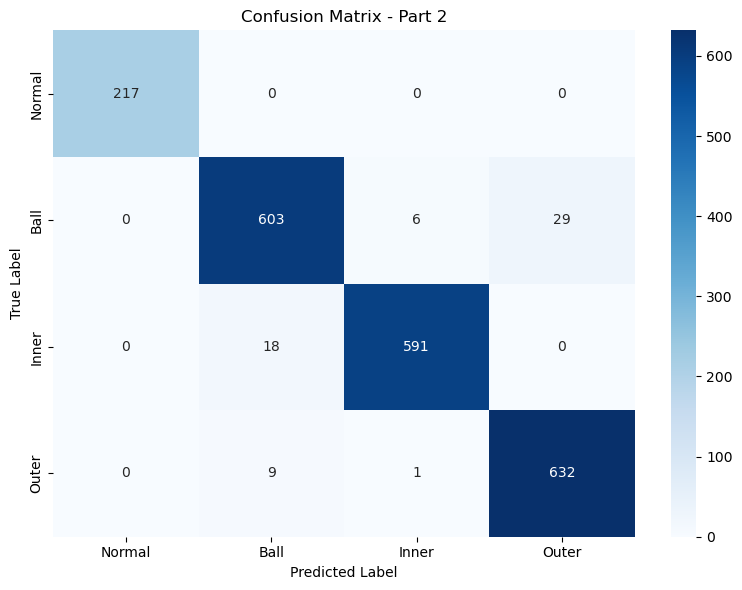

In [34]:
# Predict class labels
y_pred_part2 = model_part2.predict(X_test)
y_pred_classes_part2 = np.argmax(y_pred_part2, axis=1)

# Print classification report
print("Classification Report (Part 2):")
print(classification_report(y_test, y_pred_classes_part2))

# Confusion matrix
conf_matrix_part2 = confusion_matrix(y_test, y_pred_classes_part2)
plt.figure(figsize=(8, 6))
class_labels = ['Normal', 'Ball', 'Inner', 'Outer']
sns.heatmap(conf_matrix_part2, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Part 2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


❓ Q: Examine the classification report and confusion matrix for Part 2. How does the model’s performance compare to Part 1? Which class benefited most from data augmentation, and what does this tell you about the effect of augmentation on model accuracy and generalization?

✅A: 

# Part3 

## Step 1: Build Deeper 1D CNN Model (6 Conv Layers)

In [37]:
#❓Q: Write the complete code to define and compile model_part3 with the following architecture specifications:
#Input shape: (1600, 1)
#The model must contain 6 convolutional blocks, each block consisting of:
#Conv1D with kernel size 3 and 'same' padding
#ReLU activation
#MaxPooling1D with pool size 2
#The number of filters in each block is as follows:
#Block 1 → 32 filters
#Block 2 → 64 filters
#Block 3 → 128 filters
#Block 4, 5, 6 → 256 filters each
#After the convolutional blocks:
#Use Flatten()
#Add a Dense layer with 128 units and 'relu' activation
#Apply Dropout with rate 0.5
#Add the final output layer: Dense(4, activation='softmax')
#Compile the model using:
#Adam optimizer with learning_rate = 0.0002
#loss = 'sparse_categorical_crossentropy'
#metrics = ['accuracy']
#Hint: Use Sequential() and Keras layers just like in previous parts.

model_part3 = xxxx([
    xxxx


## Step 2: Train the Model on Augmented Data

In [39]:
#❓Q: Write the code to train model_part3 using the combined training dataset (original + augmented) and EarlyStopping.
#Use the following training configuration:
#Training data: X_train_combined, y_train_combined
#Validation data: X_test, y_test
#Epochs: 50
#Batch size: 64
#EarlyStopping:
#monitor 'val_loss'
#patience: 5
#restore best weights: True
#Store the training history in a variable named history_part3.

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.4837 - loss: 1.0583 - val_accuracy: 0.7887 - val_loss: 0.5688
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 68s 220ms/step - accuracy: 0.7980 - loss: 0.5161 - val_accuracy: 0.8504 - val_loss: 0.3654
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.8431 - loss: 0.3761 - val_accuracy: 0.8708 - val_loss: 0.2626
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.8656 - loss: 0.2974 - val_accuracy: 0.8789 - val_loss: 0.2348
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8742 - loss: 0.2609 - val_accuracy: 0.8689 - val_loss: 0.2470
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.8946 - loss: 0.2176 - val_accuracy: 0.8960 - val_loss: 0.1917
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8960 - loss: 0.2156 - val_accuracy: 0.8927 - val_loss: 0.1952
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.8961 - loss: 0.2129 

## Step 3: Evaluate the Model

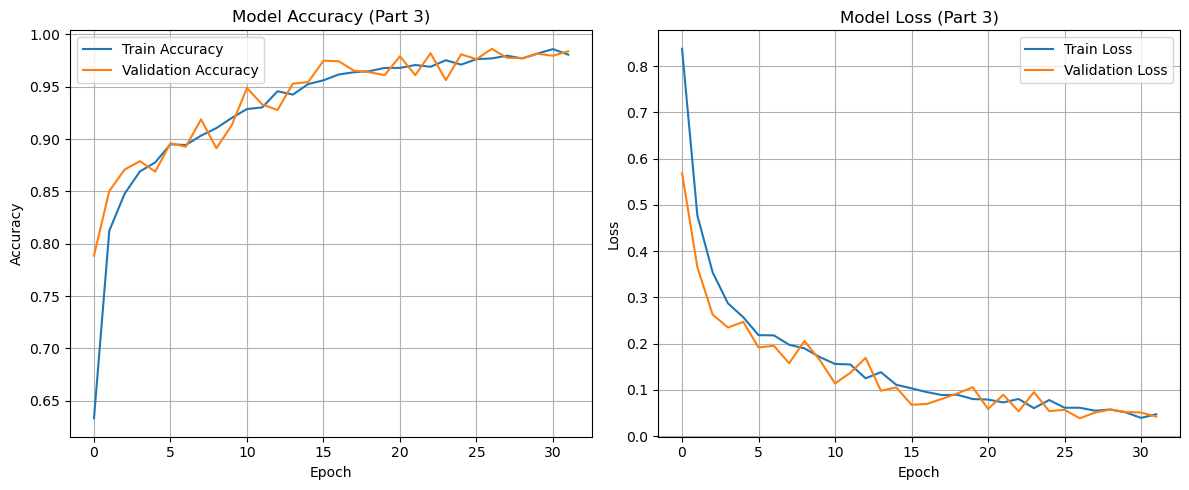

In [41]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_part3.history['accuracy'], label='Train Accuracy')
plt.plot(history_part3.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy (Part 3)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_part3.history['loss'], label='Train Loss')
plt.plot(history_part3.history['val_loss'], label='Validation Loss')
plt.title("Model Loss (Part 3)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


❓ Q: Analyze the accuracy and loss plots for model_part3. How does its training and validation performance compare to model_part1 and model_part2? What can you conclude about the impact of using a deeper CNN architecture on model performance?

✅A: 

## Step 4: Classification Report and Confusion Matrix

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Classification Report (Part 3):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       0.97      0.99      0.98       638
           2       1.00      1.00      1.00       609
           3       0.99      0.97      0.98       642

    accuracy                           0.99      2106
   macro avg       0.99      0.99      0.99      2106
weighted avg       0.99      0.99      0.99      2106



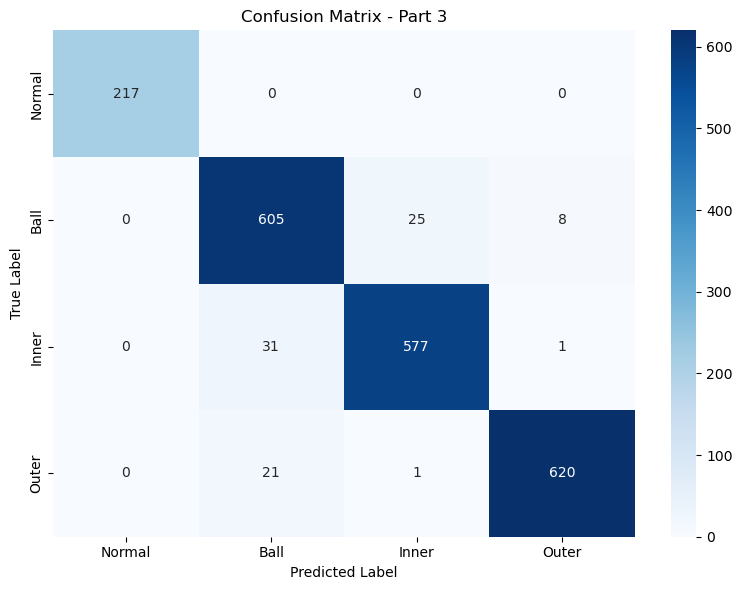

In [43]:
# Predict class labels
y_pred_part3 = model_part3.predict(X_test)
y_pred_classes_part3 = np.argmax(y_pred_part3, axis=1)

# Print classification report
print("Classification Report (Part 3):")
print(classification_report(y_test, y_pred_classes_part3))

# Compute confusion matrix
conf_matrix_part3 = confusion_matrix(y_test, y_pred_classes_part3)

plt.figure(figsize=(8, 6))
class_labels = ['Normal', 'Ball', 'Inner', 'Outer']
sns.heatmap(conf_matrix_part1, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Part 3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


❓ Q: Analyze the classification report and confusion matrix for model_part3. How well did the model perform on each class? Are there any classes that are still confused with others? What do these results tell you about the strengths and limitations of your model?

✅A: 

## Step 5: Compare accuracy of three parts

In [45]:
# Accuracy for Part 1
acc1 = history_part1.history['val_accuracy'][-1] if 'history_part1' in globals() else None

# Accuracy for Part 2
acc2 = history_part2.history['val_accuracy'][-1] if 'history_part2' in globals() else None

# Accuracy for Part 3
acc3 = history_part3.history['val_accuracy'][-1]

# Display
print(f"Validation Accuracy - Part 1: {acc1:.4f}")
print(f"Validation Accuracy - Part 2: {acc2:.4f}")
print(f"Validation Accuracy - Part 3: {acc3:.4f}")


Validation Accuracy - Part 1: 0.9520
Validation Accuracy - Part 2: 0.9634
Validation Accuracy - Part 3: 0.9839


❓ Q: Based on the printed validation accuracy values of Part 1, Part 2, and Part 3, which model performed best? What does this suggest about the effect of increasing model complexity and using data augmentation? Explain briefly.

✅A:

❓ Q: You have trained and evaluated three CNN models (Part 1, Part 2, and Part 3) on vibration signal data from the CWRU dataset. The models differed in terms of architecture depth and use of data augmentation.

Summarize what you learned from the following aspects:

Data preparation: How was the signal segmented and labeled?

Data augmentation: What techniques were used and how did they help?

Model design: What were the differences in architecture between Part 1, 2, and 3?

Training & evaluation: How did EarlyStopping and performance plots help you analyze the training process?

Final comparison: Which model performed best and why? What trade-offs should be considered when making a model deeper?

✅A: